In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchsummary import summary
import torch.nn.functional as F
from sentinelhub import (SHConfig, DataCollection, SentinelHubCatalog, SentinelHubRequest, BBox, bbox_to_dimensions, CRS, MimeType, Geometry)
from typing import Any, Optional, Tuple
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box, Polygon
from shapely.strtree import STRtree
from shapely.ops import unary_union

# 1. Creation of a dataset

## 1.1 Satellite image download

In [3]:
config = SHConfig()

config.sh_client_id = "xxx"
config.sh_client_secret = "xxx"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

config = SHConfig("cdse")

In [4]:
aoi_coords_wgs84 = [113.935089, 30.314773, 114.629974, 30.770277]

resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {aoi_size} pixels')

catalog = SentinelHubCatalog(config=config)
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
time_interval = '2022-07-01', '2022-07-20'

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},

)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Image shape at 10 m resolution: (6791, 4890) pixels
Total number of results: 34


[{'id': 'S2A_MSIL2A_20220718T025541_N0400_R032_T49RGP_20220718T081000.SAFE',
  'properties': {'datetime': '2022-07-18T03:09:48.858Z'}},
 {'id': 'S2A_MSIL2A_20220718T025541_N0400_R032_T50RKU_20220718T081000.SAFE',
  'properties': {'datetime': '2022-07-18T03:09:46.469Z'}},
 {'id': 'S2A_MSIL2A_20220718T025541_N0400_R032_T49RGQ_20220718T081000.SAFE',
  'properties': {'datetime': '2022-07-18T03:09:34.158Z'}},
 {'id': 'S2A_MSIL2A_20220718T025541_N0400_R032_T50RKV_20220718T081000.SAFE',
  'properties': {'datetime': '2022-07-18T03:09:32.119Z'}},
 {'id': 'S2B_MSIL2A_20220716T030529_N0400_R075_T49RGP_20220716T053331.SAFE',
  'properties': {'datetime': '2022-07-16T03:19:37.293Z'}},
 {'id': 'S2B_MSIL2A_20220716T030529_N0400_R075_T50RKU_20220716T053331.SAFE',
  'properties': {'datetime': '2022-07-16T03:19:33.945Z'}},
 {'id': 'S2B_MSIL2A_20220716T030529_N0400_R075_T49RGQ_20220716T053331.SAFE',
  'properties': {'datetime': '2022-07-16T03:19:23.029Z'}},
 {'id': 'S2B_MSIL2A_20220716T030529_N0400_R075_T

In [5]:
# Define the start and end dates
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 8, 31)

# List to store the intervals
intervals = []

# Generate one-month-long intervals
current_date = start_date
while current_date < end_date:
    next_date = current_date + relativedelta(months=1)
    if next_date > end_date:
        next_date = end_date
    intervals.append((current_date, next_date))
    current_date = next_date


ints_final = [(interval[0].strftime('%Y-%m-%d'), interval[1].strftime('%Y-%m-%d')) for interval in intervals]

In [6]:
# Define the bounding box coordinates
east, south, west, north = 113.935089, 30.314773, 114.629974, 30.770277

# Calculate strides for splitting the area into smaller tiles
stride_ew = (west - east) / 3
stride_ns = (north - south) / 2

# Define the tiles by splitting the bounding box into smaller areas
tiles = [
    [east, south, east + stride_ew, south + stride_ns],  # Tile 01
    [east + stride_ew, south, east + 2 * stride_ew, south + stride_ns],  # Tile 02
    [east + 2 * stride_ew, south, west, south + stride_ns],  # Tile 03
    [east, south + stride_ns, east + stride_ew, north],  # Tile 11
    [east + stride_ew, south + stride_ns, east + 2 * stride_ew, north],  # Tile 12
    [east + 2 * stride_ew, south + stride_ns, west, north]  # Tile 13
]

# Sentinel Hub configuration
resolution = 10
catalog = SentinelHubCatalog(config=config)

# Define the evalscript for true color images
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

imgs = []
for interval in ints_final:
    for tile in tiles:
        aoi_bbox = BBox(bbox=tile, crs=CRS.WGS84)
        # Adjust size to fit within API limits (2500x2500 pixels)
        aoi_size = (2500, 2500)

        # Create the Sentinel Hub request
        request_true_color = SentinelHubRequest(
            evalscript=evalscript_true_color,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A.define_from(
                        name="s2", service_url="https://sh.dataspace.copernicus.eu"
                    ),
                    time_interval=(interval[0], interval[1]),
                    other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=aoi_bbox,
            size=aoi_size,  # Use the adjusted size
            config=config,
        )

        # Get the image data
        img = request_true_color.get_data()
        imgs.append(img)
        print(interval)

('2022-05-01', '2022-06-01')
('2022-05-01', '2022-06-01')
('2022-05-01', '2022-06-01')
('2022-05-01', '2022-06-01')
('2022-05-01', '2022-06-01')
('2022-05-01', '2022-06-01')
('2022-06-01', '2022-07-01')
('2022-06-01', '2022-07-01')
('2022-06-01', '2022-07-01')
('2022-06-01', '2022-07-01')
('2022-06-01', '2022-07-01')
('2022-06-01', '2022-07-01')
('2022-07-01', '2022-08-01')
('2022-07-01', '2022-08-01')
('2022-07-01', '2022-08-01')
('2022-07-01', '2022-08-01')
('2022-07-01', '2022-08-01')
('2022-07-01', '2022-08-01')
('2022-08-01', '2022-08-31')
('2022-08-01', '2022-08-31')
('2022-08-01', '2022-08-31')
('2022-08-01', '2022-08-31')
('2022-08-01', '2022-08-31')
('2022-08-01', '2022-08-31')


In [7]:
images_merged = []

for i in range(4):

    rng = imgs[(6*i):(6*i + 6)]

    bottom_half = np.concatenate((rng[0][0], rng[1][0], rng[2][0]), axis = 1)
    top_half = np.concatenate((rng[3][0], rng[4][0], rng[5][0]), axis = 1)
    merged = np.concatenate((top_half, bottom_half), axis = 0)
    images_merged.append(merged)

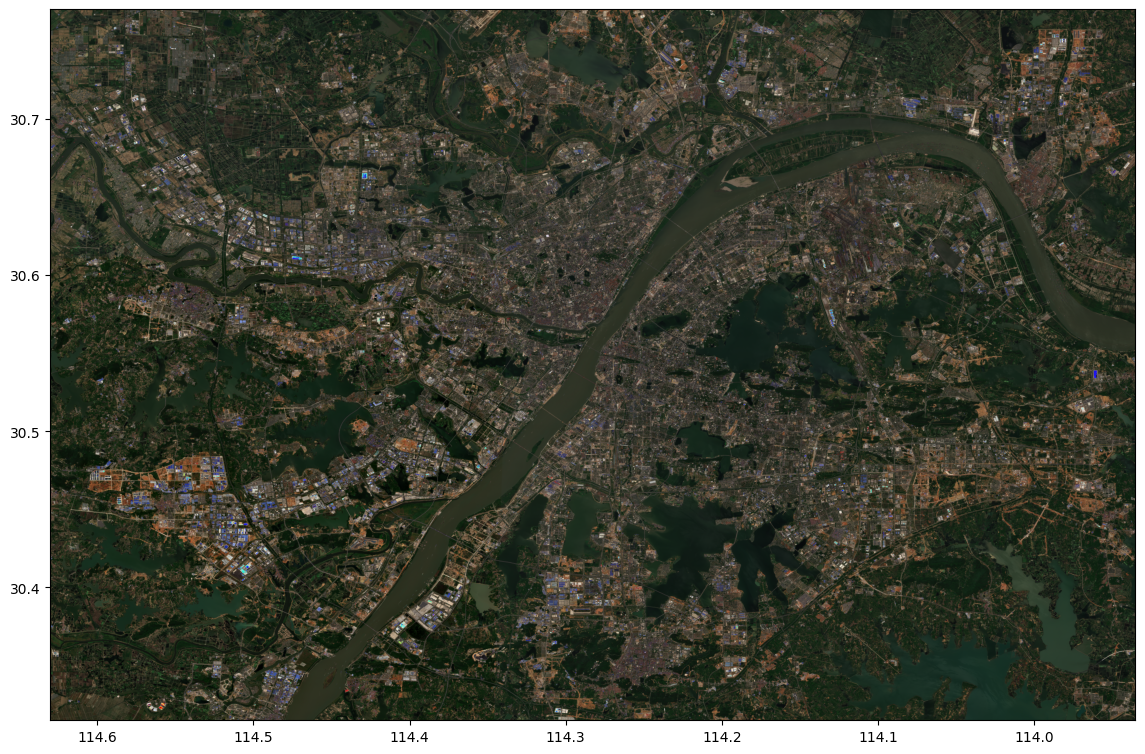

In [14]:
plt.figure(figsize = (14,14))
plt.imshow(images_merged[0]*2,  extent=[west, east, south, north])

## 1.2 Open Street Map data download

In [1]:
# Disable the cache to avoid filesystem issues
ox.config(use_cache=False)

# Define the bounding box
north, south, east, west = 30.770277, 30.314773, 114.629974, 113.935089
bbox = (north, south, east, west)

# Define tags of interest
tags = {
    'leisure': ['park', 'garden'],
    'natural': ['water', 'wood', 'grassland', 'scrub', 'heath'],
    'landuse': ['forest', 'meadow', 'grass', 'recreation_ground'],
    'waterway': ['river', 'stream', 'canal', 'ditch', 'lake'],
    'amenity': ['fountain']
}

# Download data
gdf = ox.geometries.geometries_from_bbox(north, south, east, west, tags = tags)
print('downloaded')
# Function to check if any tags match the specified categories
def is_green_space(tags, row):
    for key, values in tags.items():
        if key in row and row[key] in values:
            return True
    return False

green_spaces = gdf[gdf.apply(lambda row: is_green_space(tags, row), axis=1)]
print('gr_space')
# Aggregate green space geometries into a single polygon or multipolygon
green_space_union = unary_union(green_spaces.geometry)
print('gr_spaceunion')

C:\Users\m-a-a\AppData\Local\Temp\ipykernel_23428\1176657195.py:10: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=False)
C:\Users\m-a-a\AppData\Local\Temp\ipykernel_23428\1176657195.py:30: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries.geometries_from_bbox(north, south, east, west, tags = tags)
C:\Users\m-a-a\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\geometries.py:48: Futur

downloaded
gr_space
gr_spaceunion


In [2]:
# Create a grid with 10m resolution
resolution = 100 / 111111  # degrees per meter (approx)
x_coords = np.arange(west, east, resolution)
y_coords = np.arange(south, north, resolution)

# Initialize the numpy array to store land classification
land_classification = np.zeros((len(x_coords), len(y_coords)), dtype=np.uint8)
print('landclass')

landclass


In [3]:
len(x_coords)

773

In [4]:
from joblib import Parallel, delayed
import multiprocessing

In [5]:
## parallel attempt

num_cores = multiprocessing.cpu_count()

def classify_cell(i, j, x, y, resolution, green_space_union):
    cell = box(x, y, x + resolution, y + resolution)
    if cell.intersects(green_space_union):
        return 1
    else:
        return 0


results = Parallel(n_jobs=num_cores)(
    delayed(classify_cell)(i, j, x, y, resolution, green_space_union)
    for i, x in enumerate(x_coords)
    for j, y in enumerate(y_coords)
)

In [6]:
land_classification = np.array(results).reshape(len(x_coords), len(y_coords)).transpose()

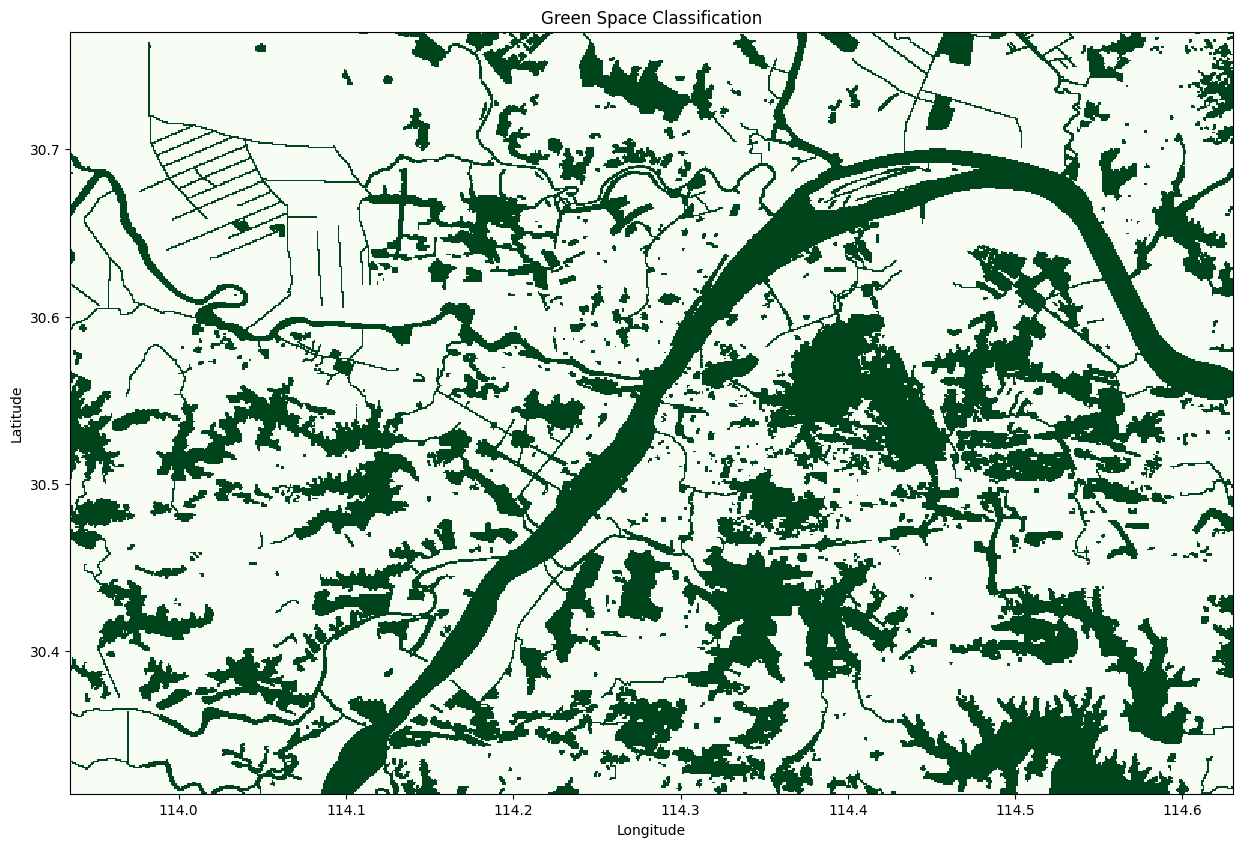

In [8]:
# Plot the land classification
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
plt.imshow(np.flipud(land_classification), cmap='Greens', interpolation='nearest', extent=[west, east, south, north])
plt.title('Green Space Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## 1.3 Image slicing

In [2]:
images_merged = []

for i in range(4):

    rng = imgs_[(6*i):(6*i + 6)]

    bottom_half = np.concatenate((rng[0][0], rng[1][0], rng[2][0]), axis = 1)
    top_half = np.concatenate((rng[3][0], rng[4][0], rng[5][0]), axis = 1)
    merged = np.concatenate((top_half, bottom_half), axis = 0)
    images_merged.append(merged)


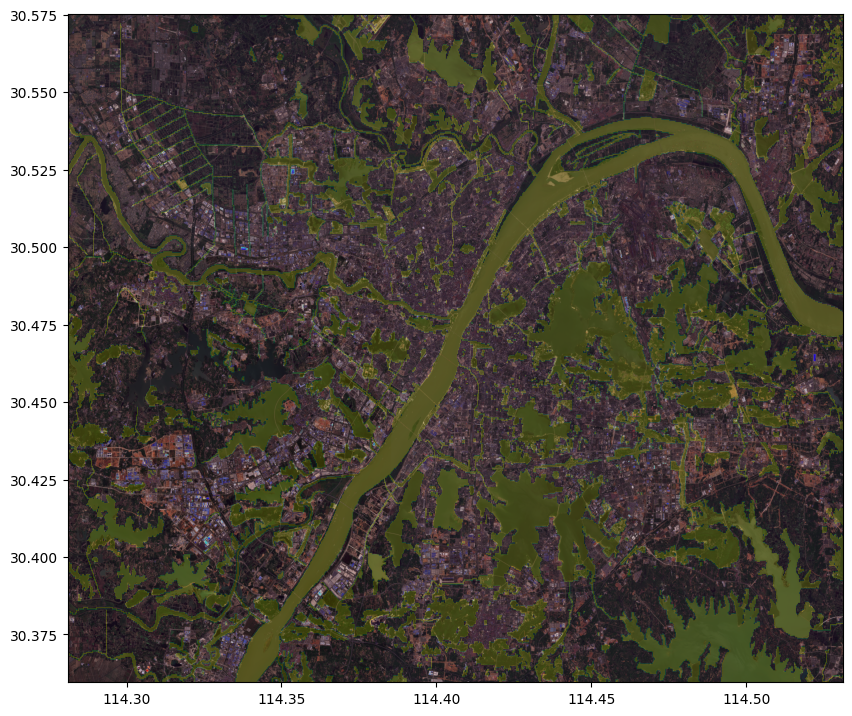

In [4]:
# Plotting the images
north, south, east, west = 30.575148340998922, 30.35955365900108, 114.53119478353574, 114.28106121646425

plt.figure(figsize = (10,10))
plt.imshow(images_merged[0]*2,  extent=[west, east, south, north])
plt.imshow(np.exp(land_class), alpha=0.2, extent=[west, east, south, north])

In [5]:
# Assuming images_merged and land_class are numpy arrays
image1_resolution = images_merged[0].shape
image2_resolution = land_class.shape

print("Resolution of the first image (images_merged[0]):", image1_resolution)
print("Resolution of the second image (land_class):", image2_resolution)

Resolution of the first image (images_merged[0]): (4934, 6876, 3)
Resolution of the second image (land_class): (507, 773)


In [6]:
# Convert the numpy array to a compatible type (uint8)
land_class_uint8 = land_class.astype(np.uint8)

# Convert the numpy array to a PIL image
land_class_image = Image.fromarray(land_class_uint8)

# Resize the image to match the dimensions of images_merged[0]
land_class_resized_image = land_class_image.resize((images_merged[0].shape[1], images_merged[0].shape[0]), Image.LANCZOS)

# Convert the PIL image back to a numpy array
land_class_resized = np.array(land_class_resized_image)

# Get the resolution of the resized land_class
resized_resolution = land_class_resized.shape
print("Resolution of the resized second image (land_class_resized):", resized_resolution)

Resolution of the resized second image (land_class_resized): (4934, 6876)


In [8]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [9]:
# Parameters
window_size = (512, 512)
initial_step_size = 100
step_increment = 25

# Lists to store patches
satellite_patches = []
green_zones_patches = []

# Sliding window over the satellite image and green zones image
for idx, image in enumerate(images_merged):
    step_size = initial_step_size + idx * step_increment
    # Sliding window over the current satellite image and green zones image
    for (x, y, window) in sliding_window(image, step_size, window_size):
        satellite_patches.append(window)
        green_zones_patch = land_class_resized[y:y + window_size[1], x:x + window_size[0]]
        green_zones_patches.append(green_zones_patch)

# Convert lists to numpy arrays
satellite_patches = np.array(satellite_patches)
green_zones_patches = np.array(green_zones_patches)

In [10]:
print(f"Total number of satellite patches: {len(satellite_patches)}")
print(f"Total number of green zones patches: {len(green_zones_patches)}")

Total number of satellite patches: 6968
Total number of green zones patches: 6968


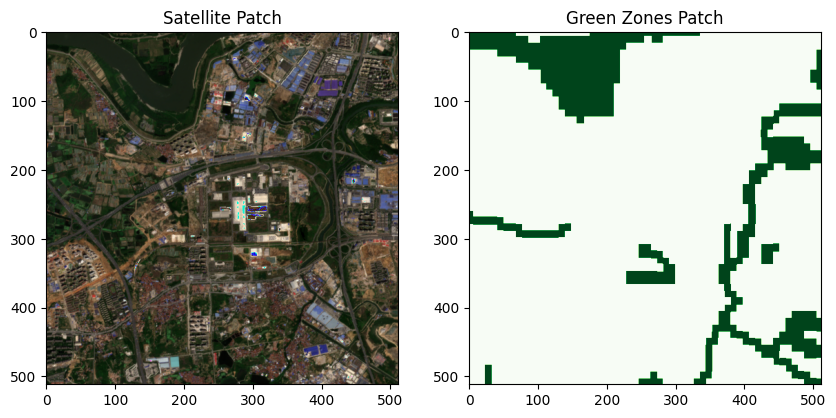

In [11]:
# Display some patches for verification
i = 1234

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(satellite_patches[i]*2)
plt.title('Satellite Patch')
plt.subplot(1, 2, 2)
plt.imshow(green_zones_patches[i], cmap='Greens')
plt.title('Green Zones Patch')
plt.show()

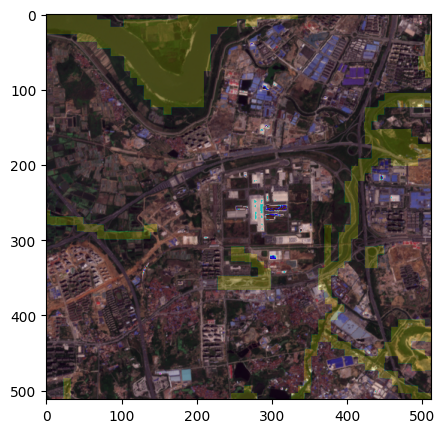

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(satellite_patches[i]*2)
plt.imshow(green_zones_patches[i], alpha=0.2)
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
satellite_patches = np.load('/kaggle/input/images/satellite_patches.npy')
green_zones_patches = np.load('/kaggle/input/images/green_zones_patches.npy')

# 2. Model training

In [4]:
# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# define EarlyStopping
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Final Convolution
        self.final_layer = nn.Conv2d(64, 1, kernel_size=1)  # 1 output channel for binary segmentation

    def forward(self, x):
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        middle = self.middle(enc2_pool)
        
        up2 = self.up2(middle)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        output = self.final_layer(dec1)
        return output

# Instantiate and check model
model = UNet().to(device)
summary(model, input_size=(3, 48, 48))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          36,928
              ReLU-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,584
              ReLU-9          [-1, 128, 24, 24]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

In [7]:
def train_unet_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            data, target = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            
            output = model(data)
            output = output.squeeze(1)  # Option 1: Squeeze the channel dimension from the output
            
            loss = criterion(output, target)  # OR use target.unsqueeze(1) for Option 2
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                data, target = batch[0].to(device), batch[1].to(device)
                
                output = model(data)
                output = output.squeeze(1)  # Option 1: Squeeze the channel dimension from the output
                
                loss = criterion(output, target)  # OR use target.unsqueeze(1) for Option 2
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses


In [8]:
# Split the data into train+val and test sets
satellite_train_val, satellite_test, green_zones_train_val, green_zones_test = train_test_split(
    satellite_patches, green_zones_patches, test_size=0.2, random_state=42)

# Split the train+val set into separate train and validation sets
satellite_train, satellite_val, green_zones_train, green_zones_val = train_test_split(
    satellite_train_val, green_zones_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 of the original dataset


In [9]:
# parameters 
batch_size = 10
epochs = 70
patience = 5
lr = 0.001
reg = 0.0001

In [10]:
# DataLoader Preparation

# Convert the numpy arrays to PyTorch tensors and permute the dimensions
satellite_train = torch.tensor(satellite_train, dtype=torch.float32).permute(0, 3, 1, 2)
green_zones_train = torch.tensor(green_zones_train, dtype=torch.float32)

satellite_val = torch.tensor(satellite_val, dtype=torch.float32).permute(0, 3, 1, 2)
green_zones_val = torch.tensor(green_zones_val, dtype=torch.float32)

satellite_test = torch.tensor(satellite_test, dtype=torch.float32).permute(0, 3, 1, 2)
green_zones_test = torch.tensor(green_zones_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(satellite_train, green_zones_train)
val_dataset = TensorDataset(satellite_val, green_zones_val)
test_dataset = TensorDataset(satellite_test, green_zones_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# initialize model, loss, and optimizer
model = UNet().to(device)

# If it's a binary segmentation, use BCEWithLogitsLoss. If it's multi-class, use CrossEntropyLoss.
criterion = nn.BCEWithLogitsLoss() 

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
early_stopper = EarlyStopping(patience=patience)

Epoch: 1, Training Loss: 0.5239, Validation Loss: 0.4701
Validation loss decreased (0.470087 --> 0.470087).  Saving model ...
Epoch: 2, Training Loss: 0.4961, Validation Loss: 0.5020
Epoch: 3, Training Loss: 0.4858, Validation Loss: 0.4554
Validation loss decreased (0.470087 --> 0.455437).  Saving model ...
Epoch: 4, Training Loss: 0.4456, Validation Loss: 0.5051
Epoch: 5, Training Loss: 0.4290, Validation Loss: 0.3991
Validation loss decreased (0.455437 --> 0.399098).  Saving model ...
Epoch: 6, Training Loss: 0.4046, Validation Loss: 0.4176
Epoch: 7, Training Loss: 0.3996, Validation Loss: 0.3917
Validation loss decreased (0.399098 --> 0.391660).  Saving model ...
Epoch: 8, Training Loss: 0.3906, Validation Loss: 0.3774
Validation loss decreased (0.391660 --> 0.377401).  Saving model ...
Epoch: 9, Training Loss: 0.3846, Validation Loss: 0.3667
Validation loss decreased (0.377401 --> 0.366707).  Saving model ...
Epoch: 10, Training Loss: 0.3704, Validation Loss: 0.3894
Epoch: 11, Trai

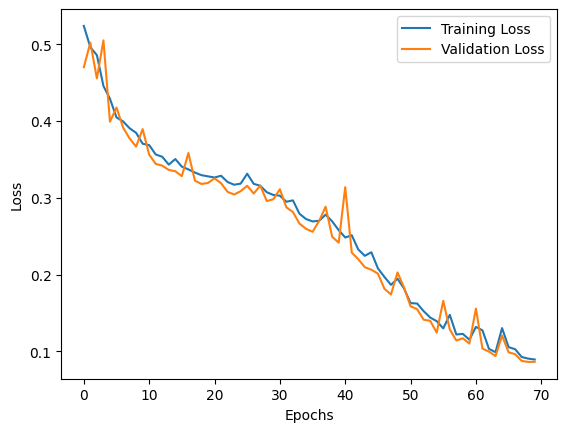

In [12]:
# Training the model
train_losses, val_losses = train_unet_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper)

# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Save the model state dictionary
torch.save(model.state_dict(), 'unet_model.pth')

In [14]:
# Save the optimizer state as well (to resume training)
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, 'unet_model_checkpoint.pth')

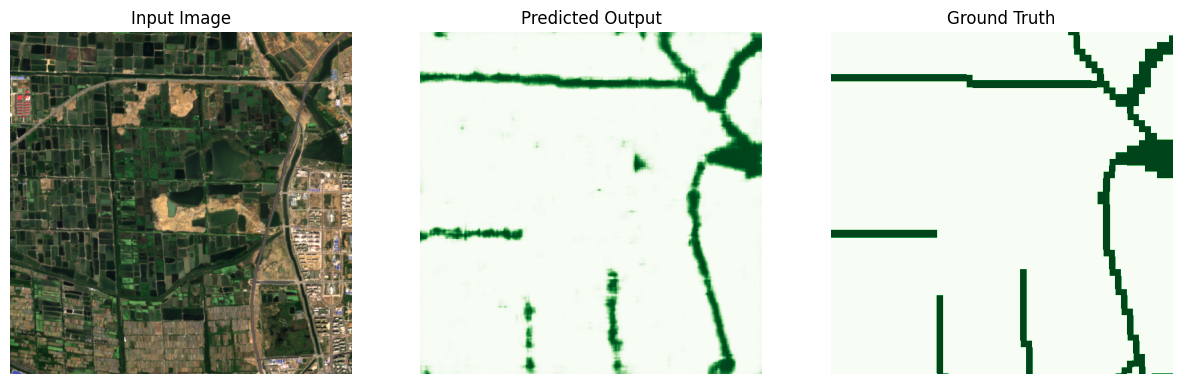

In [15]:
# Ensure the model is in evaluation mode
model.eval()

# Get the first observation from the test dataset
first_test_image, first_test_target = test_dataset[78]
first_test_image = first_test_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
first_test_target = first_test_target.cpu().numpy()  # Move target to CPU and convert to numpy array

# Run the observation through the model to get the prediction
with torch.no_grad():
    predicted_output = model(first_test_image)

# Convert the model output to an image format if necessary
predicted_output = torch.sigmoid(predicted_output)  # Apply sigmoid to get probabilities
predicted_output = predicted_output.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU

# Convert input image to a numpy array
first_test_image_np = first_test_image.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

# Rescale the input image if necessary (assuming the input image is normalized between 0 and 1)
first_test_image_np = (first_test_image_np - first_test_image_np.min()) / (first_test_image_np.max() - first_test_image_np.min())

# Display the input image, predicted output, and ground truth
plt.figure(figsize=(15, 5))

# Plot the input image
plt.subplot(1, 3, 1)
plt.imshow(first_test_image_np*2)
plt.title('Input Image')
plt.axis('off')

# Plot the predicted output
plt.subplot(1, 3, 2)
plt.imshow(predicted_output, cmap='Greens')
plt.title('Predicted Output')
plt.axis('off')

# Plot the ground truth (desired picture)
plt.subplot(1, 3, 3)
plt.imshow(first_test_target, cmap='Greens')
plt.title('Ground Truth')
plt.axis('off')

plt.show()

# 3. Calculation of accuracy and prediction

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def threshold_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(np.uint8)

# Define a function for evaluating the model
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)  # Get model predictions
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = preds.cpu().numpy()  # Convert to numpy array
            labels = labels.cpu().numpy()  # Convert to numpy array
            
            preds = threshold_predictions(preds)
            
            # Flatten the arrays to calculate metrics
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return accuracy, precision, recall, f1

# Assuming you have a DataLoader `test_loader` for the test dataset
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9626
Precision: 0.9314
Recall: 0.9068
F1 Score: 0.9189


In [11]:
# Define the function to divide the image into patches
def divide_into_patches(image, patch_size):
    patches = []
    img_height, img_width = image.shape[:2]
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            # If the patch is not the full patch_size (due to image size), pad it
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                patch = np.pad(patch, ((0, patch_size - patch.shape[0]), (0, patch_size - patch.shape[1]), (0, 0)), mode='constant')
            patches.append(patch)
    return patches, img_height, img_width

# Define the function to merge patches into a full image
def merge_patches(patches, img_height, img_width, patch_size):
    output_img = np.zeros((img_height, img_width))
    k = 0
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            output_patch = patches[k]
            patch_height, patch_width = output_patch.shape[:2]
            output_img[i:i + patch_height, j:j + patch_width] = output_patch[:patch_height, :patch_width]
            k += 1
    return output_img

# Load the input image
image = np.load('SAVE/wuhan_2017.npy')[0:4608, 0:6656]

# Divide the image into patches
patch_size = 512
patches, img_height, img_width = divide_into_patches(image, patch_size)

# Predict the labels for each patch
model.eval()
predicted_patches = []
with torch.no_grad():
    for patch in patches:
        # Convert the patch to a tensor and normalize it if necessary
        input_patch = torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).float()  # Convert to (1, 3, H, W)
        predicted_patch = model(input_patch)
        predicted_patch = predicted_patch.squeeze().numpy()  # Convert to (H, W)
        predicted_patches.append(predicted_patch)

In [13]:
# predictions for modern 2022 image

# dividing into a size that fits 512 by 512 squares
image_2022 = X[1][0:4608, 0:6656]

# Divide the image into patches
patch_size = 512
patches_2022, img_height, img_width = divide_into_patches(image_2022, patch_size)

# Predict the labels for each patch
model.eval()
predicted_patches_22 = []
with torch.no_grad():
    for patch in patches_2022:
        # Convert the patch to a tensor and normalize it if necessary
        input_patch = torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).float()  # Convert to (1, 3, H, W)
        predicted_patch = model(input_patch)
        predicted_patch = predicted_patch.squeeze().numpy()  # Convert to (H, W)
        predicted_patches_22.append(predicted_patch)

In [35]:
# might be redundant, depending on order of code to merge predicted patches again
predicted_image17 = merge_patches(predicted_patches, img_height, img_width, patch_size)
predicted_image_22 = merge_patches(predicted_patches_22, img_height, img_width, patch_size)
predicted_image17 = (predicted_image17 > 0.5).astype(np.uint8)  # Threshold for binary segmentation
predicted_image_22 = (predicted_image_22 > 0.5).astype(np.uint8)  # Threshold for binary segmentation


In [64]:
# trying a low res version
import cv2

diff = ((predicted_image_22 - predicted_image17) > 0).astype(np.uint8)
scale_factor = 0.03
small_img = cv2.resize(diff, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
low_res_img = cv2.resize(small_img, (diff.shape[1], diff.shape[0]), interpolation=cv2.INTER_LINEAR)

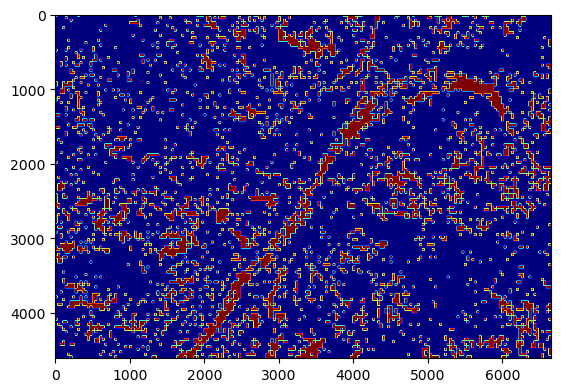

In [65]:
plt.imshow(low_res_img, cmap = 'jet')

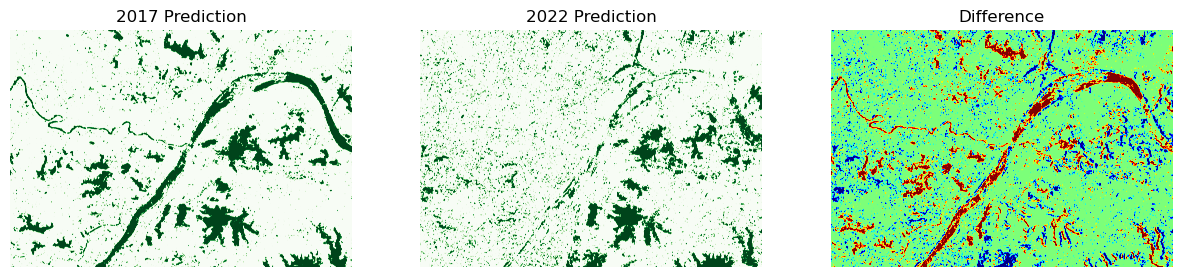

In [90]:
diff = (predicted_image_22 - predicted_image17)
plt.figure(figsize=(15, 5))

# Plot the input image
plt.subplot(1, 3, 1)
plt.imshow(predicted_image17> 0.5, cmap = 'Greens')
plt.title('2017 Prediction')
plt.axis('off')

# Plot the predicted output
plt.subplot(1, 3, 2)
plt.imshow(predicted_image_22 > 0.5, cmap='Greens')
plt.title('2022 Prediction')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(-(diff) + 1  , cmap='jet')
plt.title('Difference')
plt.axis('off')

plt.savefig('figs/preds_2017_2022.png', format='png')

plt.show()
